In [1]:
import pandas as pd
import os

# 데이터 디렉토리
data_dir = "/home/jovyan/work/data"

all_data = []

# 각 테이블에서 데이터 추출
tables = [
    ('accounts_blockrecord_processed.csv', 'user_id'),
    ('accounts_failpaymenthistory.csv', 'user_id'),
    ('accounts_paymenthistory.csv', 'user_id'),
    ('accounts_pointhistory.csv', 'user_id'),
    ('accounts_timelinereport.csv', 'user_id'),
    ('accounts_user_processed.csv', 'id'),  # id가 user_id 역할
    ('accounts_userquestionrecord_processed.csv', 'user_id'),
    ('event_receipts.csv', 'user_id'),
    ('polls_questionreport.csv', 'user_id'),
    ('polls_questionset.csv', 'user_id')
]

# 일반 테이블들 처리
for file_name, user_col in tables:
    df = pd.read_csv(os.path.join(data_dir, file_name))
    temp_df = df[[user_col, 'created_at']].copy()
    temp_df.columns = ['user_id', 'created_at']
    temp_df['table_name'] = file_name.replace('.csv', '')
    all_data.append(temp_df)

# 친구 요청 테이블 - 보낸 사람만 포함 (능동적 활동)
df_friend = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 보낸 사람만 (능동적 활동)
temp_send = df_friend[['send_user_id', 'created_at']].copy()
temp_send.columns = ['user_id', 'created_at']
temp_send['table_name'] = 'accounts_friendrequest_send'
all_data.append(temp_send)

# 모든 데이터 병합
merged_df = pd.concat(all_data, ignore_index=True)

# created_at을 datetime으로 변환
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], format='ISO8601', errors='coerce')

# null 값 제거
merged_df = merged_df.dropna(subset=['created_at'])

# user_id로 그룹화하고 created_at으로 정렬
merged_df = merged_df.sort_values(['user_id', 'created_at']).reset_index(drop=True)

print(f"총 {len(merged_df):,}개 레코드 병합 완료")
print(f"유니크 사용자 수: {merged_df['user_id'].nunique():,}")
print("\n테이블별 레코드 수:")
print(merged_df['table_name'].value_counts())

총 21,705,813개 레코드 병합 완료
유니크 사용자 수: 677,085

테이블별 레코드 수:
table_name
accounts_friendrequest_send              17147175
accounts_pointhistory                     2338918
accounts_userquestionrecord_processed     1217558
accounts_user_processed                    677085
polls_questionset                          158384
accounts_paymenthistory                     95140
polls_questionreport                        51424
accounts_blockrecord_processed              19449
event_receipts                                309
accounts_timelinereport                       208
accounts_failpaymenthistory                   163
Name: count, dtype: int64


In [2]:
import pandas as pd
import os

# 데이터 경로
data_dir = '/home/jovyan/work/data'

# 사용자 질문 기록 테이블
uq_record = pd.read_csv(os.path.join(data_dir, 'accounts_userquestionrecord_processed.csv'))

# 유저 정보 테이블
user_df = pd.read_csv(os.path.join(data_dir, 'accounts_user_processed.csv'))
user_df = user_df.rename(columns={'id': 'user_id'})  # id → user_id로 통일

In [6]:
# 공개 질문 상태: 'status' == 'C'
uq_record_public = uq_record[uq_record['status'] == 'C']

# 공개 질문 기록이 있는 유저 목록
public_users = uq_record_public['user_id'].unique()

# user_df에 공개 질문 여부 변수 추가
user_df['has_public_question'] = user_df['user_id'].isin(public_users).astype(int)


In [7]:
# 사용자별 생존기간 계산
user_survival = merged_df.groupby('user_id').agg({
    'created_at': ['first', 'last', 'count']
}).reset_index()

# 컬럼명 정리
user_survival.columns = ['user_id', 'first_activity', 'last_activity', 'total_events']

print(f"사용자 생존기간 테이블 완성: {len(user_survival):,}명")
print(user_survival.head())

# 생존일 수 계산 (차이 in days)
user_survival['survival_days'] = (user_survival['last_activity'] - user_survival['first_activity']).dt.days

# 이탈 유저 (당일 유저): 1, 잔존 유저: 0
user_survival['is_churn'] = user_survival['survival_days'].apply(lambda x: 1 if x == 0 else 0)

print(user_survival['is_churn'].value_counts())
# 1: 이탈 (하루만 활동), 0: 잔존

사용자 생존기간 테이블 완성: 677,085명
   user_id             first_activity              last_activity  total_events
0   831956 2023-03-29 03:44:14.047130 2023-03-29 03:44:14.047130             1
1   831962 2023-03-29 05:18:56.162368 2023-07-13 07:51:59.000000             2
2   832151 2023-03-29 12:56:34.989468 2023-05-09 15:50:58.000000            11
3   832340 2023-03-29 12:56:35.020790 2023-05-11 00:51:26.000000            29
4   832520 2023-03-29 12:56:35.049311 2023-03-29 12:56:35.049311             1
is_churn
0    441629
1    235456
Name: count, dtype: int64


In [8]:
# 병합
user_df = user_df.merge(user_survival[['user_id', 'is_churn']], on='user_id', how='left')
user_df['is_churn'] = user_df['is_churn'].fillna(1).astype(int)  # 활동 없는 유저는 이탈로 간주


In [9]:
from scipy.stats import chi2_contingency

# 교차표: 공개 질문 여부 vs 이탈 여부
ct = pd.crosstab(user_df['has_public_question'], user_df['is_churn'])

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(ct)

print('✅ 교차표:')
print(ct)
print(f'\nChi2 = {chi2:.2f}, p-value = {p:.10f}')


✅ 교차표:
is_churn                  0       1
has_public_question                
0                    436800  235441
1                      4829      15

Chi2 = 2553.55, p-value = 0.0000000000


| 공개 질문 여부 (`has_public_question`) | 잔존자 수 (`is_churn=0`) | 이탈자 수 (`is_churn=1`) | 잔존율       |
| :------------------------------- | -------------------- | -------------------- | --------- |
| 0 (공개 질문 없음)                     | 436,800              | 235,441              | 65.0%     |
| 1 (공개 질문 있음)                     | 4,829                | 15                   | **99.7%** |


🧪 카이제곱 독립성 검정
Chi² = 2553.55

p-value < 0.001
→ 공개 질문 여부와 잔존 여부 사이에는 매우 강한 통계적 연관성이 존재

✅ 결론
공개 질문을 한 유저는 **압도적으로 높은 잔존율(99.7%)**을 보임

이는 **“초기 적극적 공개 질문 활동이 사용자 이탈을 억제할 수 있다”**는 중요한 시사점을 제공

비록 공개 질문 유저 수 자체는 적지만, 그들의 생존 비율이 매우 높다는 점에서 중요 사용자 세그먼트로 분류 가능

📌 주의사항
전체 유저 대비 공개 질문 유저 수가 매우 적기 때문에 표본 불균형 주의

기대 빈도가 5 미만인 셀 존재 (특히 공개+이탈 셀: 15건) → Fisher의 정확 검정 병행 고려 가능

-> 스케일 차이가 애매해서 아래에서 fisher검정 시행함


In [10]:
import pandas as pd
from scipy.stats import fisher_exact

# 교차표 수치 입력
# [[has_public=1 & not churned, has_public=1 & churned],
#  [has_public=0 & not churned, has_public=0 & churned]]
contingency_table = [[4829, 15], [436800, 235441]]

# Fisher의 정확 검정 수행
oddsratio, p_value = fisher_exact(contingency_table)

oddsratio, p_value

print(f'Odds Ratio: {oddsratio:.3f}')
print(f'p-value: {p_value:.10f}')  # 소수점 이하 10자리



Odds Ratio: 173.526
p-value: 0.0000000000


오즈비 (Odds Ratio): 173.53

p-value: < 0.001

즉, 공개 질문이 있는 유저는 없는 유저에 비해 잔존할 확률이 매우 높다는 통계적으로 유의미한 결과가 나타났습니다.    
카이제곱 검정에서의 기대빈도 제한이 걱정될 때 Fisher의 검정으로도 동일한 방향성과 유의성이 확인되었습니다. 

## ✅ 가설 3

> **“타임라인에 공개 답변을 남긴 유저는 서비스를 지속적으로 이용할 가능성이 높다.”**

---

### 🔍 분석 개요

- **데이터**
  - `accounts_userquestionrecord_processed.csv`: 유저별 공개 답변 여부
  - `merged_df`: 유저별 전체 활동 기록 → 생존일 수 계산

- **종속 변수 (`is_churn`)**
  - `1`: 당일 이탈 유저
  - `0`: 2일 이상 활동한 잔존 유저

- **독립 변수 (`has_public_question`)**
  - `1`: 공개 답변 기록 있음
  - `0`: 없음

---

### 📊 1. 교차표 및 카이제곱 검정

| 공개 답변 여부 | 잔존 유저 수 | 이탈 유저 수 | 잔존율 |
|----------------|--------------|--------------|--------|
| ❌ 없음         | 436,800      | 235,441      | 65.0%  |
| ✅ 있음         | 4,829        | 15           | 99.7%  |

- **Chi² = 2553.55**, **p < 0.000000**
- → 통계적으로 유의한 연관 관계가 있음

---

### 🧪 2. Fisher의 정확 검정

- **오즈비 (Odds Ratio)**: **173.53**
- **p-value**: **< 0.00000**

> 공개 질문이 있는 유저는 없는 유저에 비해 **잔존할 확률이 매우 높음**  
> 기대빈도 제한이 걱정되는 카이제곱 검정의 한계를 보완하며, **동일한 방향성과 유의성** 확인

---

### 🧠 해석 요약

- 공개 답변을 작성한 유저는 서비스에 **높은 비율로 잔존**
- 실제 오즈비가 매우 크고 통계적으로도 유의함
- **공개 답변 유저 수는 전체에서 적지만**, 이들의 행동은 **잔존과 강한 연관성**을 보임
- 타임라인 기능 활용이 사용자 이탈 방지에 기여할 수 있음을 시사

---



In [11]:
user_survival['survival_days'] = (user_survival['last_activity'] - user_survival['first_activity']).dt.days
user_survival['is_churn'] = user_survival['survival_days'].apply(lambda x: 1 if x == 0 else 0)


In [12]:
user_plot_df = user_df.merge(user_survival[['user_id', 'is_churn']], on='user_id', how='left')
print(user_plot_df.columns)  # 'is_churn' 있는지 확인


Index(['user_id', 'is_superuser', 'is_staff', 'gender', 'point',
       'friend_id_list', 'is_push_on', 'created_at', 'block_user_id_list',
       'hide_user_id_list', 'ban_status', 'report_count', 'alarm_count',
       'pending_chat', 'pending_votes', 'group_id', 'friend_count',
       'is_point_specialist', 'is_friend_specialist', 'is_specialist',
       'specialist_type', 'has_public_question', 'is_churn_x', 'is_churn_y'],
      dtype='object')


In [13]:
# merged_df에서 사용자별 활동 기간 정리
user_survival = merged_df.groupby('user_id').agg({
    'created_at': ['first', 'last', 'count']
}).reset_index()

# 컬럼명 정리
user_survival.columns = ['user_id', 'first_activity', 'last_activity', 'total_events']

# 생존일 수 계산
user_survival['survival_days'] = (user_survival['last_activity'] - user_survival['first_activity']).dt.days

# 이탈 여부 (하루만 활동한 유저는 이탈자로 간주)
user_survival['is_churn'] = user_survival['survival_days'].apply(lambda x: 1 if x == 0 else 0)


In [14]:
# user_df에 공개질문 여부가 있다고 가정
# user_survival과 병합
user_plot_df = user_df.merge(user_survival[['user_id', 'is_churn']], on='user_id', how='left')

In [17]:
# 교차표 확인
ct = pd.crosstab(user_df['has_public_question'], user_df['is_churn'])
print('✅ 교차표:\n', ct)

# 비율 계산
prop_df = ct.div(ct.sum(axis=1), axis=0).reset_index()
print('\n✅ 비율:\n', prop_df)


✅ 교차표:
 is_churn                  0       1
has_public_question                
0                    436800  235441
1                      4829      15

✅ 비율:
 is_churn  has_public_question         0         1
0                           0  0.649767  0.350233
1                           1  0.996903  0.003097


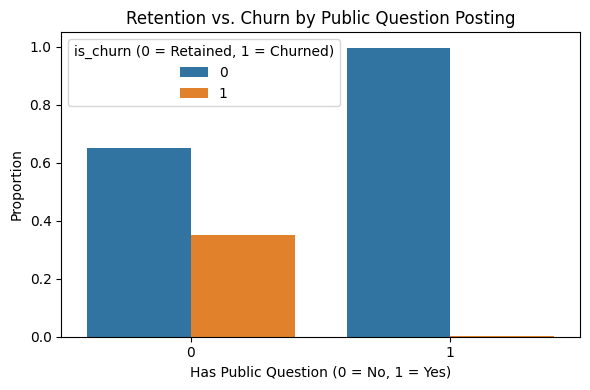

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the proportion DataFrame for plotting
# 비율 데이터프레임을 그래프 그리기 위한 형식으로 변형
plot_df = prop_df.melt(id_vars='has_public_question', var_name='is_churn', value_name='ratio')

# Plot the bar chart
# 막대 그래프 그리기
plt.figure(figsize=(6, 4))
sns.barplot(data=plot_df, x='has_public_question', y='ratio', hue='is_churn')
plt.title('Retention vs. Churn by Public Question Posting')  # 공개 질문 여부에 따른 잔존/이탈 비율
plt.xlabel('Has Public Question (0 = No, 1 = Yes)')  # 공개 질문 여부
plt.ylabel('Proportion')  # 비율
plt.ylim(0, 1.05)
plt.legend(title='is_churn (0 = Retained, 1 = Churned)')  # 잔존/이탈 여부
plt.tight_layout()
plt.show()
